# Logistic Regression Model

### Name: 
Xavier Andres Soto Baron

### UCF ID:
5601517

## Dataset

We use the Breast Cancer Wisconsin dataset from scikit-learn.  
It contains 569 samples with 30 attributes. Labels are binary:  
$$
y \in \{0,1\}
$$


In [79]:
#libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer

# random generator for reproducibility
rng = np.random.default_rng(4630)

# load dataset
data = load_breast_cancer()
X_all, y_all = data.data, data.target
target_names = data.target_names # ['malignant', 'benign']

print("Classes:", dict(zip(target_names, np.unique(y_all))))
print("Class counts:", {cls:int((y_all==cls).sum()) for cls in np.unique(y_all)})

Classes: {np.str_('malignant'): np.int64(0), np.str_('benign'): np.int64(1)}
Class counts: {np.int64(0): 212, np.int64(1): 357}


## Stratified Split

To preserve class balance, we divide the dataset into train, validation, and test sets:  
- 60% training  
- 20% validation  
- 20% testing  

Stratification ensures that the proportion of malignant/benign cases remains consistent across subsets. A malignant has: 


In [71]:
#Stratified Split 60/20/20
def stratified_split(X, y, rng, train_frac=0.6, val_frac=0.2):
    classes = np.unique(y)
    idx_train, idx_val, idx_test = [], [], []

    for c in classes:
        idx_c = np.where(y == c)[0]
        rng.shuffle(idx_c)
        n = len(idx_c)
        n_train = int(train_frac * n)
        n_val   = int(val_frac * n)

        idx_train.extend(idx_c[:n_train])
        idx_val.extend(idx_c[n_train:n_train+n_val])
        idx_test.extend(idx_c[n_train+n_val:])

    return np.array(idx_train), np.array(idx_val), np.array(idx_test)



idx_train, idx_val, idx_test = stratified_split(X_all, y_all, rng)

X_train, y_train = X_all[idx_train], y_all[idx_train]
X_val,   y_val   = X_all[idx_val], y_all[idx_val]
X_test,  y_test  = X_all[idx_test], y_all[idx_test]

#Printing splits
print("Splits:", X_train.shape, X_val.shape, X_test.shape)



Splits: (341, 30) (113, 30) (115, 30)


## Feature Standardization

To speed up gradient descent, features are standardized to zero mean and unit variance:  
$$
x' = \frac{x - \mu}{\sigma}
$$

where $\mu$ and $\sigma$ are computed from the training set only.


In [72]:
#Find mean and std from the training set
mean = X_tr.mean(axis=0)
std = X_tr.std(axis=0)

#Prevent invalid division by 0 values
std[std == 0] = 1.0

#Standardize
X_tr = (X_tr - mean) / std
X_val = (X_val - mean) / std
X_te = (X_te - mean) / std

## Logistic Regression Model

The hypothesis function:  
$$
\hat{y} = \sigma(\mathbf{w}^\top \mathbf{x}), \quad
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Decision boundary: $\hat{y}$ $\geq 0.5 \implies y=1$.


In [73]:
#Function returning Sigmoid value
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

#Function will return the probabilities for the class 1
def prob_predict(X, theta):
    return sigmoid(X @ theta)
    
#Function will return binary predictions (0 or 1)
def class_predict(X, theta, thresh=0.5):
    return (prob_predict(X, theta) >= thresh).astype(int)


## Derivation and Explanation

### Logistic Regression Hypothesis
We model the probability of the positive class as:
$$
\hat{y} = \sigma(\theta^\top \mathbf{x})
$$
where the sigmoid function is
$$
\sigma(z) = \frac{1}{1 + e^{-z}}.
$$

---

### Binary Cross-Entropy Loss
For a dataset with $m$ samples, the average loss is:
$$
J(\theta) = -\frac{1}{m} \sum_{i=1}^m \Big[ y^{(i)} \log \hat{y}^{(i)} + (1-y^{(i)}) \log(1-\hat{y}^{(i)}) \Big].
$$

This penalizes confident but wrong predictions heavily, and is convex, ensuring a global minimum.

---

### L2 Regularization
To reduce overfitting, we add a penalty on large weights.  
We do not regularize the bias term $theta_0$:

$$
J_{reg}(\theta) = J(\theta) + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2
$$


where $\lambda$ is the regularization strength.

---

### Gradient of Loss
For one sample, the derivative is:
$$
\frac{\partial \ell}{\partial \theta} = (\hat{y} - y)\mathbf{x}.
$$

For all $m$ samples, in vectorized form:
$$
\nabla J(\theta) = \frac{1}{m} X^\top (\hat{y} - y).
$$

---

### Gradient with L2 Regularization
When including the L2 term:
$$
\nabla J_{reg}(\theta) = \frac{1}{m} X^\top (\hat{y} - y) + \frac{\lambda}{m}\tilde{\theta},
$$

where
$$
\tilde{\theta} = [0, \theta_1, \theta_2, \dots, \theta_n]^\top.
$$

---

### Gradient Descent Update
Parameters are updated iteratively as:
$$
\theta \leftarrow \theta - \alpha \, \nabla J_{reg}(\theta),
$$

where $\alpha$ is the learning rate.




In [74]:
#Function for loss
def loss_fn(X, y, theta, lam=0.0):
    m = len(y)
    p = np.clip(prob_predict(X, theta), 1e-15, 1-1e-15)
    loss = -(1/m) * np.sum(y*np.log(p) + (1-y)*np.log(1-p))
    loss += (lam/(2*m)) * np.sum(theta[1:]**2)
    return loss

#Function for Gradient
def grad_fn(X, y, theta, lam=0.0):
    m = len(y)
    p = prob_predict(X, theta)
    grad = (1/m) * (X.T @ (p - y))
    grad[1:] += (lam/m) * theta[1:]
    return grad


## Training

Parameters are updated iteratively:  
$$
\mathbf{w} \leftarrow \mathbf{w} - \alpha \, \nabla J_{reg}(\mathbf{w})
$$

where $\alpha$ is the learning rate.


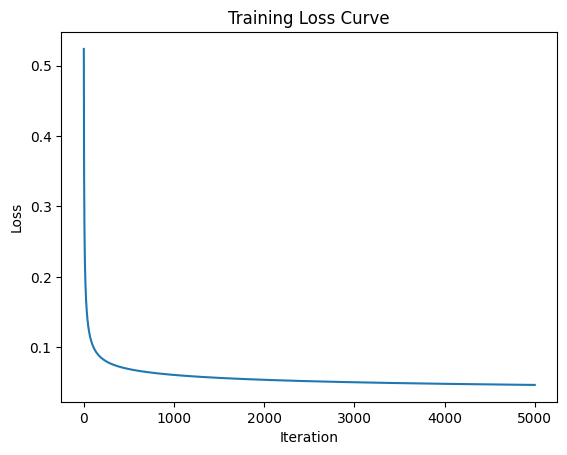

In [75]:
def fit_log_reg(X, y, lr=0.1, lam=0.0, iters=5000):
    theta = np.zeros(X.shape[1])
    history = []
    for _ in range(iters):
        theta -= lr * grad_fn(X, y, theta, lam)
        history.append(loss_fn(X, y, theta, lam))
    return theta, history

weights, history = fit_log_reg(X_tr, y_tr, lr=0.1, lam=0.1, iters=5000)

#Print graph
plt.plot(history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()


## Evaluation Metrics

From the confusion matrix:

- Accuracy = $\dfrac{TP + TN}{TP + TN + FP + FN}$
  
- Precision = $\dfrac{TP}{TP + FP}$
  
- Recall = $\dfrac{TP}{TP + FN}$
  
- F1 = $2 \cdot \dfrac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$  



In [76]:
def confusion(y_true, y_pred):
    tp = np.sum((y_true==1) & (y_pred==1))
    tn = np.sum((y_true==0) & (y_pred==0))
    fp = np.sum((y_true==0) & (y_pred==1))
    fn = np.sum((y_true==1) & (y_pred==0))
    return tp, tn, fp, fn

def evaluate(X, y, theta):
    preds = class_predict(X, theta)
    tp, tn, fp, fn = confusion(y, preds)
    acc = (tp+tn)/(tp+tn+fp+fn)
    prec = tp/(tp+fp+1e-15)
    rec = tp/(tp+fn+1e-15)
    f1 = 2*prec*rec/(prec+rec+1e-15)
    return acc, prec, rec, f1, (tp, tn, fp, fn)

#Print values
acc, prec, rec, f1, cm = evaluate(X_te, y_te, weights)
print("Test Set Metrics \n")
print("Accuracy:", f"{acc:.3f}")
print("Precision:", f"{prec:.3f}")
print("Recall:", f"{rec:.3f}")
print("F1 Score:", f"{f1:.3f}")
print("Confusion Matrix (TP, TN, FP,FN) : ")
print(cm)



Test Set Metrics 

Accuracy: 0.974
Precision: 0.960
Recall: 1.000
F1 Score: 0.980
Confusion Matrix (TP, TN, FP,FN) : 
(np.int64(72), np.int64(40), np.int64(3), np.int64(0))


## Predictions on First 5 Test Samples

We display true labels, predicted probabilities, and predicted classes for the first five test points.


In [77]:
#Predictions for 5 labels
probs5 = prob_predict(X_te[:5], weights)
preds5 = class_predict(X_te[:5], weights)

print("First 5 Test Examples \n")
print("True:", y_te[:5])
print("Probabilities:", np.round(probs5,3))
print("Predictions:", preds5)


First 5 Test Examples 

True: [0 0 0 0 0]
Probabilities: [0.    0.002 0.    0.    0.   ]
Predictions: [0 0 0 0 0]


## Predictions on First 5 Test Examples

| Example | True Label | Predicted Probability | Predicted Class |
|---------|------------|-----------------------|-----------------|
| 1       | 0          | 0.000                 | 0               |
| 2       | 0          | 0.002                 | 0               |
| 3       | 0          | 0.000                 | 0               |
| 4       | 0          | 0.000                 | 0               |
| 5       | 0          | 0.000                 | 0               |



## Learned Parameters

The final coefficients $\theta$ show how each feature contributes to the decision boundary.


In [78]:
#Iterating to print Learned Coefficients
for i, coef in enumerate(weights):
    print(f"θ{i}: {coef:.6f}")


θ0: -0.126089
θ1: -0.312788
θ2: -0.115569
θ3: -0.395835
θ4: -0.353439
θ5: 0.563031
θ6: -1.173688
θ7: -1.151157
θ8: -0.275087
θ9: 0.217467
θ10: -1.783867
θ11: -0.122158
θ12: -1.380149
θ13: -1.338629
θ14: 0.494546
θ15: 1.530492
θ16: 0.208300
θ17: -0.152157
θ18: 0.560683
θ19: 0.793227
θ20: -1.110064
θ21: -1.244615
θ22: -1.010563
θ23: -1.385628
θ24: -0.592730
θ25: -0.069398
θ26: -1.451473
θ27: -1.092618
θ28: -0.998170
θ29: -0.406959


## Final Test Set Results

- **Accuracy:** 0.974  
- **Precision:** 0.960  
- **Recall:** 1.000  
- **F1 Score:** 0.980  

**Confusion Matrix (TP, TN, FP, FN):** (72, 40, 3, 0)  

- TP = 72 → Malignant tumors correctly identified  
- TN = 40 → Benign tumors correctly identified  
- FP = 3  → Benign tumors incorrectly labeled malignant  
- FN = 0  → No malignant tumors missed  

